### Курсовая работа по курсу Python для Data Science

**Задание проекта:**
Используя данные из train.csv,построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv

In [3]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [5]:
# Функция для отображения результатов
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

Пути к датасетам

In [6]:
DATASET_PATH = 'train.csv'
DATASET_test = 'test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

* **Price** - цена квартиры


Обзор датасетов

In [7]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
df_test = pd.read_csv(DATASET_test)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


Работаем с train.csv

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


#### Проводим обзор признаков

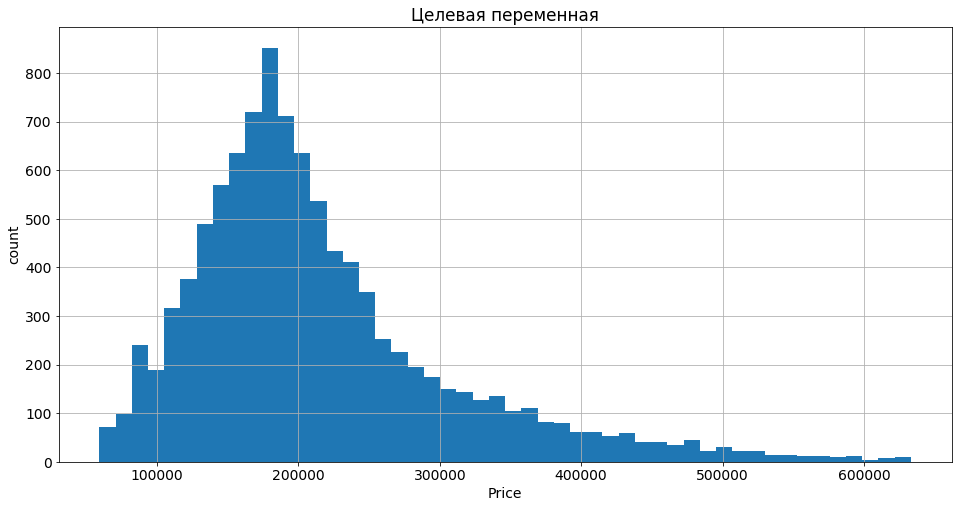

In [10]:
plt.figure(figsize = (16, 8))
df['Price'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Целевая переменная')
plt.show()

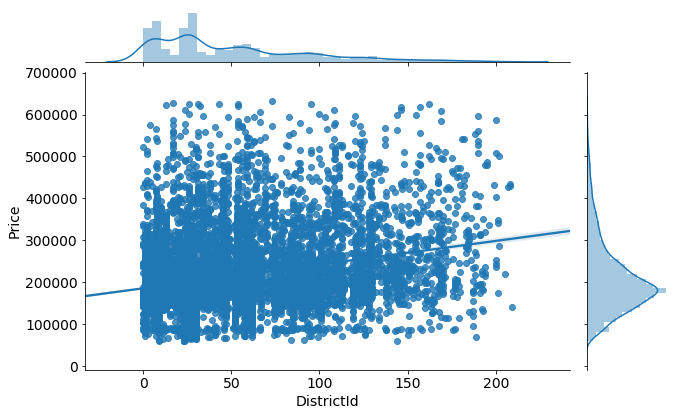

In [11]:
# График распределения цены по району
grid_1 = sns.jointplot(df['DistrictId'],df['Price'], kind = 'reg')
grid_1.fig.set_figwidth(10)
grid_1.fig.set_figheight(6)
plt.show()

In [12]:
# функция построения графиков для обзора
def show_plt(df):
    plt.hist(df['Square'], bins = 50, alpha = 0.2);
    plt.title('общая площадь')
    plt.show()
    plt.hist(df['LifeSquare'], bins = 50, alpha = 0.2);
    plt.title('жилая площадь')
    plt.show()
    plt.hist(df['KitchenSquare'], bins = 50, alpha = 0.2);
    plt.title('кухня')
    plt.show()

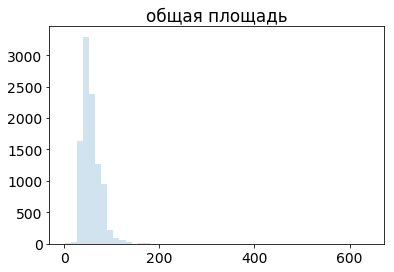

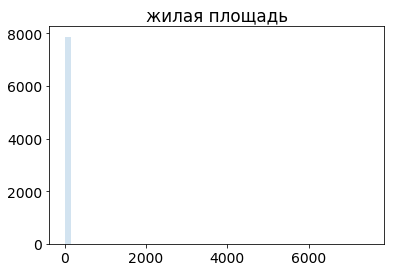

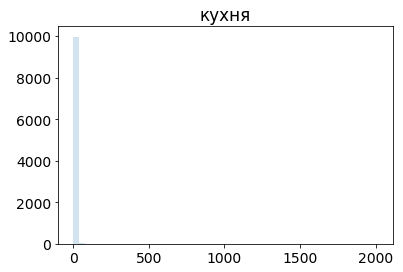

In [13]:
show_plt(df)

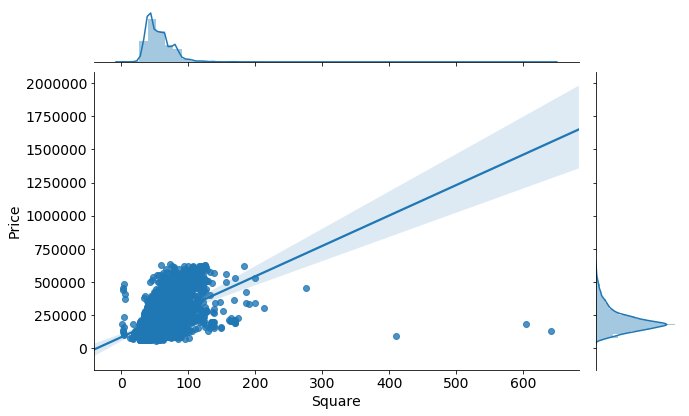

In [14]:
# График распределения цены и общей площади
grid_1 = sns.jointplot(df['Square'],df['Price'], kind = 'reg')
grid_1.fig.set_figwidth(10)
grid_1.fig.set_figheight(6)
plt.show()

In [15]:
df.loc[(df['Square'] > df['LifeSquare'])].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993
10,15370,28,2.0,46.304907,27.922584,6.0,8,9.0,1973,0.118537,B,B,30,6207,1,1183.0,1,0,B,204243.553129
11,12427,31,3.0,68.808859,45.736906,7.0,1,8.0,1959,0.000000,B,B,23,3684,2,NaN,0,4,B,165534.541425


In [16]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
df.loc[df['Floor']>df['HouseFloor']].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
35,6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,NaN,2,5,B,402871.916317
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
51,10103,94,1.0,35.280894,23.354176,6.0,11,9.0,1971,0.282798,B,B,33,8667,2,NaN,0,6,B,148862.210174


In [18]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


проводим обзор датасета test

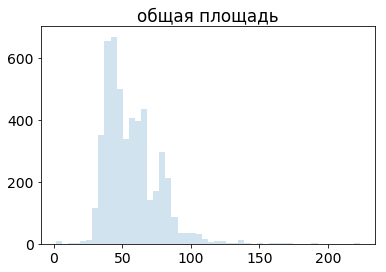

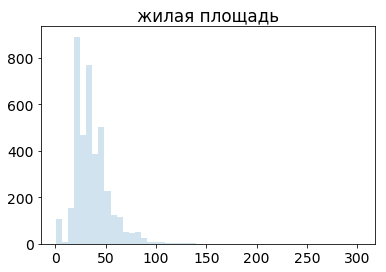

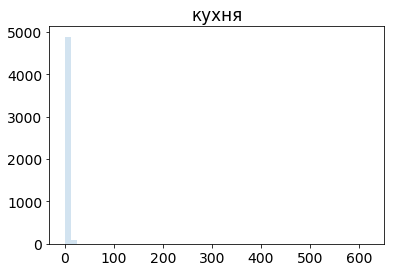

In [19]:
show_plt(df_test)

In [20]:
df_test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

#### Видим, что оба датасета имеют выбросы, которые требуют обработки
создадим функцию по предобработке датасета

In [21]:
# функция для обработки датасета
def prepared (df):
    # обрабатываем ошибочные данные по числу комнат
    df.loc[(df['Rooms']>5) | (df['Rooms']<1),'Rooms']=df['Rooms'].median()
    
    # Обрабатываем ошибочные данные общей площади
    sqr_median = dict(df.groupby('Rooms')['Square'].median())
    pat=((df['Square']>250) | (df['Square']<15))
    df.loc[pat,'Square']=df.loc[pat,'Rooms'].apply(lambda x: sqr_median[x])
    
    # Обрабатываем ошибочные данные жилой площади
    lsqr_median = dict(df.groupby('Rooms')['LifeSquare'].median())
    pat=((df['LifeSquare'].isnull()) | (df['LifeSquare']>150) | (df['LifeSquare']<15))
    df.loc[pat,'LifeSquare']=df.loc[pat,'Rooms'].apply(lambda x: lsqr_median[x])
    df.loc[(df['Square'] > 90) & (df['Rooms'] == 1), 'Rooms'] = df['Rooms'].median()
    
    # Обрабатываем ошибочные данные площади кухни
    df.loc[(df['KitchenSquare']>20) | (df['KitchenSquare']<5),'KitchenSquare'] = df['KitchenSquare'].median()
    
    # HouseFloor и  Floor. Считаем, что данные перепутаны местами
    for i in df.loc[df['Floor']>df['HouseFloor'],'Floor'].index:
        floor = df['Floor'][i]
        df['Floor'][i]=df['HouseFloor'][i]
        df['HouseFloor'][i]=floor
    pat=((df['HouseFloor']>40) & (df['HouseYear']<1990))
    df.loc[pat,'HouseFloor']=df.loc[pat,'Floor']
    
    # Заменяем ошибочные данные в HouseYear
    df.loc[df['HouseYear']>2019,'HouseYear']=2019
    
    # Healthcare_1. Заменяем пропуски медианой
    df.loc[df['Healthcare_1'].isnull(),'Healthcare_1']=df['Healthcare_1'].median()
    
    df=pd.get_dummies(df)
    
    return df

Обрабатываем датасет train

In [22]:
df = prepared(df)
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,900.0,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,229.0,1,3,220925.908524,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,175616.227217,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,150226.531644,0,1,0,1,0,1
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,990.0,0,6,215898.447742,0,1,0,1,0,1
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,900.0,1,5,296021.204377,0,1,0,1,0,1
7,11993,74,2.0,80.312926,32.554849,6.0,0,14.0,1977,0.075779,...,900.0,0,2,221244.156664,0,1,0,1,0,1
8,5172,1,2.0,64.511437,32.554849,6.0,9,17.0,1977,0.007122,...,900.0,0,1,229102.795999,0,1,0,1,0,1
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,900.0,0,2,95380.220993,0,1,0,1,0,1


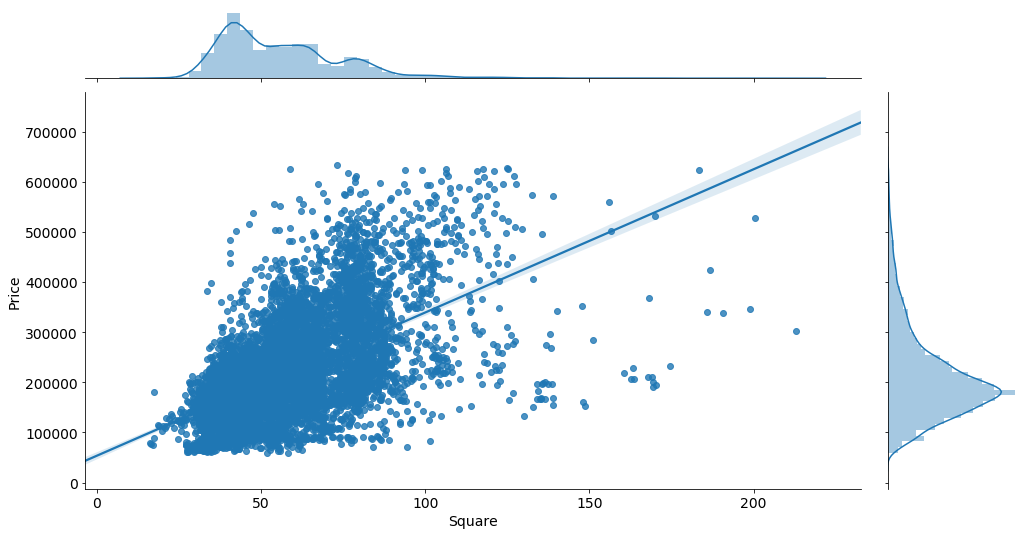

In [23]:
# Проверяем график распределения цены и общей площади
grid_1 = sns.jointplot(df['Square'],df['Price'], kind = 'reg')
grid_1.fig.set_figwidth(16)
grid_1.fig.set_figheight(8)
plt.show()

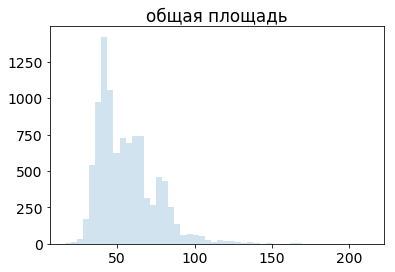

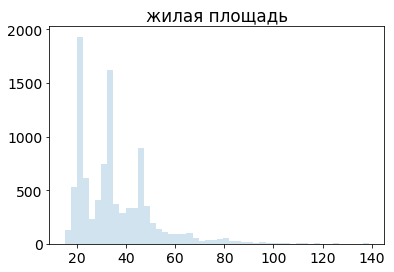

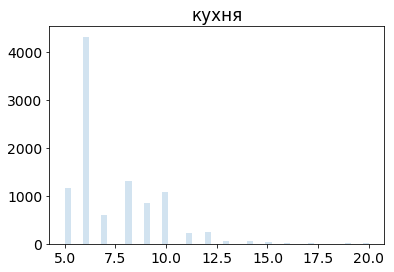

In [24]:
#Проверяем признаки после обработки
show_plt(df)

Обзор вещественных переменных

### Матрица корреляций

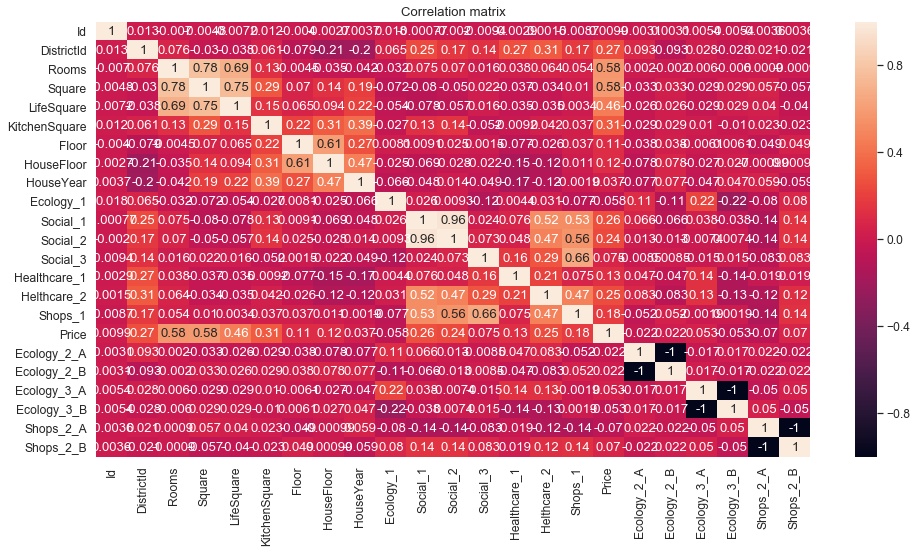

In [25]:
plt.figure(figsize=(16,8))
sns.set(font_scale = 1.1)
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [26]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [27]:
feature_=[
'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1',
 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B',
 'Shops_2_A', 'Shops_2_B'
]
target_='Price'

In [28]:
df=df[feature_+[target_]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,...,900.0,0,11,0,1,0,1,0,1,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,...,240.0,1,16,0,1,0,1,0,1,300009.450063
2,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,34,...,229.0,1,3,0,1,0,1,0,1,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,...,1084.0,0,5,0,1,0,1,0,1,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,...,2078.0,2,4,0,1,0,1,0,1,150226.531644


### Стандартизация признаков

In [29]:
feature_stand=[
    'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1',
 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1'
]
feature_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [30]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_stand])
df[feature_stand]=pd.DataFrame(scl_f,columns=feature_stand)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,-0.353348,0.134722,-0.434252,-0.390027,-0.623367,-0.132056,-0.748938,-0.861979,-0.250529,0.474169,...,-0.169240,-0.883480,1.408356,0,1,0,1,0,1,184966.930730
1,-0.215687,1.369575,0.499920,0.303538,0.307101,-0.132056,-0.748938,-0.373153,-0.998053,1.215681,...,-1.053217,-0.213923,2.448700,0,1,0,1,0,1,300009.450063
2,0.059635,0.134722,-0.594341,-0.406056,-0.623367,0.056488,-0.239006,-0.916293,-0.581588,0.531208,...,-1.067950,-0.213923,-0.256195,0,1,0,1,0,1,220925.908524
3,0.174352,0.134722,-0.150792,1.132795,0.772334,0.056488,0.610883,-0.427467,2.680470,-0.096225,...,0.077202,-0.883480,0.159943,0,1,0,1,0,1,175616.227217
4,1.115034,-1.100130,-0.873967,-0.760557,-0.158133,0.622121,-0.239006,-0.481781,-0.894969,0.588247,...,1.408526,0.455633,-0.048126,0,1,0,1,0,1,150226.531644


### Разбиение на train и test

In [31]:
X = df[feature_]
y = df[target_]
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = True, random_state = 42 )

### Обучение и оценка модели

In [32]:
model_best = GradientBoostingRegressor(n_estimators = 450,max_depth = 5 ,random_state=42, learning_rate=0.05, subsample=0.9)
model_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=450, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=0.9, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.913
MAE:	18437.021
MSE:	749034513.147


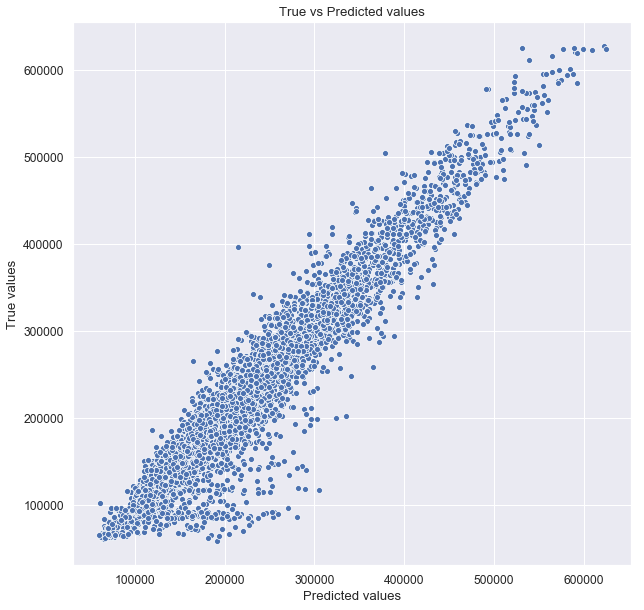

R2:	0.746
MAE:	27134.064
MSE:	2238009519.535


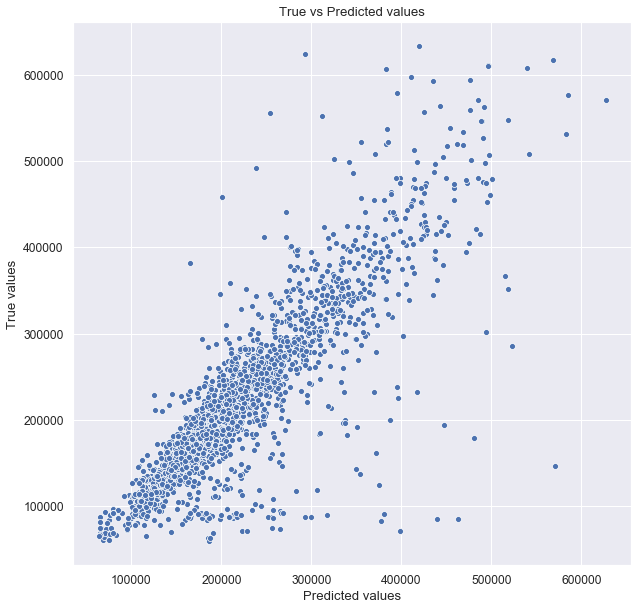

In [33]:
y_pred_=model_best.predict(X_train)
evaluate_preds(y_train, y_pred_)

y_pred_t=model_best.predict(X_test)
evaluate_preds(y_test, y_pred_t)

**Обрабатываем test.csv**

In [34]:
df_test = prepared(df_test)
X_scalled = scl.transform(df_test[feature_stand])
df_test[feature_stand]=pd.DataFrame(X_scalled,columns=feature_stand)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,725,0.174352,0.134722,-0.333928,-0.129124,-0.623367,-0.320601,0.100950,-0.699037,1.607652,...,-0.295384,-0.169240,-0.883480,-0.880402,0,1,0,1,0,1
1,15856,0.541447,0.134722,0.688820,-0.168370,-0.623367,-1.263322,-1.258871,-0.427467,-0.361948,...,-0.211458,-0.169240,-0.883480,-0.464264,0,1,0,1,0,1
2,5480,3.202888,-1.100130,-0.849243,-1.272415,2.168035,-1.074778,-1.428849,-4.120816,-0.998641,...,3.313409,4.923005,2.464303,0.159943,0,1,0,1,0,1
3,15664,-0.078026,0.134722,0.888478,1.081095,0.772334,2.696107,1.460771,1.201951,-0.142708,...,-0.211458,-0.169240,1.125190,-0.256195,0,1,0,1,0,1
4,14275,-0.536895,-1.100130,-0.458234,0.521807,-0.623367,1.753386,0.610883,1.745091,-0.392373,...,-0.295384,-0.169240,-0.883480,-0.880402,0,1,0,1,1,0


In [35]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,0.020154,0.021610,0.016449,0.021643,-0.016144,0.025944,-0.006544,-0.026044,0.008540,...,0.009374,0.004068,-0.000067,0.002393,0.009600,0.990400,0.029800,0.970200,0.082400,0.917600
std,4832.674037,1.013630,0.993837,1.000940,1.002506,0.981824,1.028507,1.027691,1.008596,1.008826,...,1.001388,1.026747,0.990903,0.994021,0.097518,0.097518,0.170052,0.170052,0.275001,0.275001
min,1.000000,-1.156369,-1.100130,-2.105145,-1.333124,-1.088600,-1.451866,-2.108760,-4.175130,-0.998641,...,-0.337347,-1.374664,-0.883480,-0.880402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4221.750000,-0.674556,-1.100130,-0.754533,-0.833065,-0.623367,-0.697689,-0.748938,-0.644723,-0.834728,...,-0.337347,-0.289782,-0.883480,-0.672333,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8320.500000,-0.307461,0.134722,-0.173380,-0.168370,-0.623367,-0.132056,0.100950,-0.427467,-0.392373,...,-0.253421,-0.169240,-0.213923,-0.256195,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12598.250000,0.610278,0.134722,0.531662,0.605212,0.772334,0.622121,0.610883,0.821754,0.646311,...,-0.127533,-0.048698,0.455633,0.368011,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16795.000000,3.707644,3.839281,8.825745,6.637843,5.889904,7.221169,5.880189,1.853719,3.386085,...,5.579395,5.119891,3.133859,3.905183,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Предсказываем цену на недвижимость

In [36]:
y_pred_= model_best.predict(df_test[feature_])
y_pred_

array([152214.6166865 , 203937.72964845, 209955.68196464, ...,
       316852.0167626 , 190849.07895331, 182581.800341  ])

In [37]:
Price_pred = pd.DataFrame({
    'Id': df_test['Id'],
    'Price': y_pred_
})
Price_pred.head()

,Id,Price
0,725,152214.616687
1,15856,203937.729648
2,5480,209955.681965
3,15664,364269.680891
4,14275,142665.840680


Сохраняем предсказание в файл

In [38]:
# проверяем размерность
Price_pred.shape

(5000, 2)

In [39]:
Price_pred.to_csv('AShabalin_predictions.csv', sep=',', index=False, encoding='utf-8')